# 6 Binary Classification Exercise - hotel
Deep Learning Kaggle course tutorial: https://www.kaggle.com/code/soyoungchoe/exercise-binary-classification/edit

Build a model to predict hotel cancellations with a binary classifier

In [5]:
import pandas as pd 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

hotel = pd.read_csv('hotel.csv')

X = hotel.copy()
y = X.pop('is_canceled')

X['arrival_date_month'].map(
    {'January':1, 'February': 2, 'March':3,
        'April':4, 'May':5, 'June':6, 'July':7,
        'August':8, 'September':9, 'October':10,
        'November':11, 'December':12}
)

features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# Stratify - make sure classes are evenly represented across splits - see the explanation for detail
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]

print("input_shape is ", input_shape)

input_shape is  [63]


#### About stratify (asked ChatGPT)
the stratify parameter ensures that the distribution of the target variable in the original dataset is maintained in the training and validation sets. This is particularly useful when dealing with imbalanced datasets, where the classes in the target variable may not be evenly distributed. Using stratify helps in producing representative subsets for training and validation that reflect the overall distribution of the target variable.

## Define Model by using batch normalization and dropout layers


In [8]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])


## Add Optimizer, Loss, and Metric
Compile the model with the adam optimizer and binary versions of the cross-entropy loss and accuracy metric.

In [9]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

## Train the Model

Epoch 1/200
175/175 [==============================] - 7s 25ms/step - loss: 0.4869 - binary_accuracy: 0.7694 - val_loss: 0.4360 - val_binary_accuracy: 0.7969
Epoch 2/200
175/175 [==============================] - 3s 18ms/step - loss: 0.4245 - binary_accuracy: 0.7996 - val_loss: 0.4053 - val_binary_accuracy: 0.8154
Epoch 3/200
175/175 [==============================] - 3s 16ms/step - loss: 0.4085 - binary_accuracy: 0.8086 - val_loss: 0.3978 - val_binary_accuracy: 0.8187
Epoch 4/200
175/175 [==============================] - 3s 20ms/step - loss: 0.4008 - binary_accuracy: 0.8121 - val_loss: 0.3925 - val_binary_accuracy: 0.8175
Epoch 5/200
175/175 [==============================] - 3s 17ms/step - loss: 0.3961 - binary_accuracy: 0.8141 - val_loss: 0.3904 - val_binary_accuracy: 0.8216
Epoch 6/200
175/175 [==============================] - 3s 18ms/step - loss: 0.3917 - binary_accuracy: 0.8165 - val_loss: 0.3842 - val_binary_accuracy: 0.8236
Epoch 7/200
175/175 [==============================]

<Axes: title={'center': 'Accuracy'}>

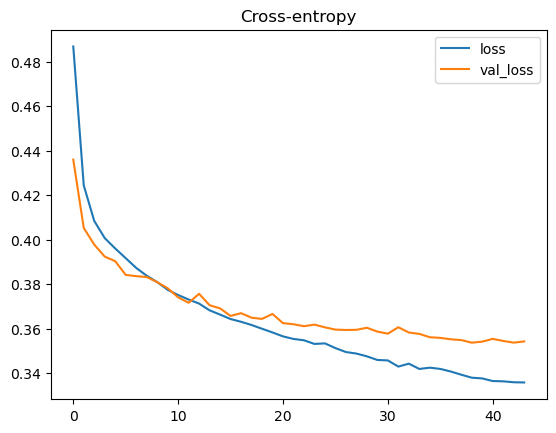

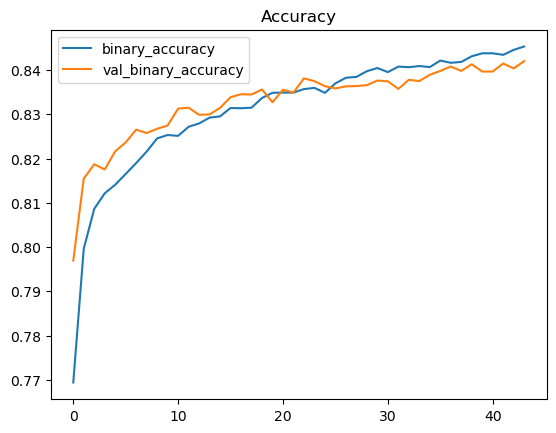

In [10]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss','val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy','val_binary_accuracy']].plot(title="Accuracy")